<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/nursery_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 保育所
- input:
    - [（認可）保育所](https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000099/resource/f3a1b2c5-a037-4627-9166-2a4863bf3bd9)
    - [児童館](https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000099/resource/ef6db4bc-966b-48cd-88ac-5922d413ad0b)
    - 待機児童数
- output:
    - nursery_score.csv
        - 保育園スコア
        - 児童館スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_master_file = 'nursery_master.csv'
output_score_file = 'nursery_score.csv'

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

### 保育所

In [7]:
nursery_url = 'https://www.opendata.metro.tokyo.lg.jp/fukushihoken/R3/202110-2-1-hoikusyo.csv'
df_nursery = get_data_csv_url(nursery_url, encoding='shift-jis')
print(df_nursery.shape)

(3431, 9)


In [8]:
df_nursery['市区町村名'] = df_nursery['所在地'].str.extract('(^.*?[区市])', expand=False)
df_nursery['施設分類'] = '認可保育所'

df_nursery_master = df_nursery[
    (df_nursery['市区町村名'].notna())&
    (df_nursery['市区町村名'].str.endswith('区'))&
    (df_nursery['市区町村名'].str.len() < 5)
][['市区町村名', '施設分類', '設置', '施設名', '所在地', '緯度', '経度', '定員']].rename(columns={'施設名':'名称'}).reset_index(drop=True)
print(df_nursery_master.shape)

assert df_nursery_master['市区町村名'].nunique() == 23

(2526, 8)


### 待機児童数
- [令和4年4月1日の区市町村別の状況](https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2022/07/27/01.html)

In [9]:
waiting_children = {
    '千代田区': 0,
    '中央区': 0,
    '港区': 0,
    '新宿区': 0,
    '文京区': 2,
    '台東区': 6,
    '墨田区': 7,
    '江東区': 0,
    '品川区': 0,
    '目黒区': 0,
    '大田区': 0,
    '世田谷区': 0,
    '渋谷区': 0,
    '中野区': 0,
    '杉並区': 0,
    '豊島区': 0,
    '北区': 16,
    '荒川区': 0,
    '板橋区': 0,
    '練馬区': 0,
    '足立区': 1,
    '葛飾区': 0,
    '江戸川区': 0,
}

### 児童館

In [10]:
childrenhouse_url = 'https://www.opendata.metro.tokyo.lg.jp/fukushihoken/R3/202110-2-2-06-zidoukan.csv'
df_childrenhouse = get_data_csv_url(childrenhouse_url, encoding='shift-jis')
print(df_childrenhouse.shape)

(587, 9)


In [11]:
df_childrenhouse['市区町村名'] = df_childrenhouse['所在地'].str.extract('(^.*?[区市])', expand=False)
df_childrenhouse['施設分類'] = '児童館'

df_childrenhouse_master = df_childrenhouse[
    (df_childrenhouse['市区町村名'].notna())&
    (df_childrenhouse['市区町村名'].str.endswith('区'))&
    (df_childrenhouse['市区町村名'].str.len() < 5)
][['市区町村名', '施設分類', '設置', '施設名', '所在地', '緯度', '経度']].rename(columns={'施設名':'名称'}).reset_index(drop=True)
print(df_childrenhouse_master.shape)

assert df_childrenhouse_master['市区町村名'].nunique() == 23

(439, 7)


### 保育所マスタ

In [12]:
df_nursery_master = pd.concat([df_nursery_master, df_childrenhouse_master]).reset_index(drop=True)
print(df_nursery_master.shape)

(2965, 8)


In [13]:
df_nursery_master.to_csv(os.path.join(DIR_NAME, output_master_file), index=False, encoding='utf-8_sig')

In [14]:
df_nursery_master.head()

,市区町村名,施設分類,設置,名称,所在地,緯度,経度,定員
0,千代田区,認可保育所,営利法人,ほっぺるランド外神田,千代田区外神田４−８−６,35.70233,139.77260,87.0
1,千代田区,認可保育所,社福法人,外神田かなりや保育園,千代田区外神田３−６−１３,35.70255,139.76976,50.0
2,千代田区,認可保育所,区市町村,いずみこども園,千代田区神田和泉町１,35.69919,139.77597,36.0
3,千代田区,認可保育所,営利法人,あい保育園東神田,千代田区東神田２−６−５ 東神田ビル２・３階,35.69564,139.78027,63.0
4,千代田区,認可保育所,社福法人,岩本町ちとせ保育園,千代田区岩本町２−１０−１２,35.69344,139.77722,69.0


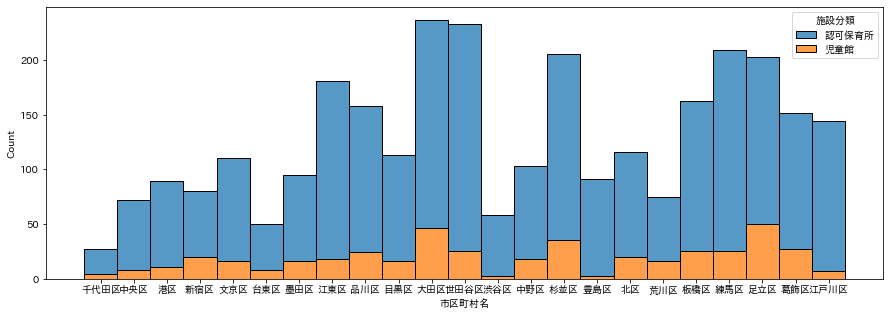

In [15]:
plt.figure(figsize=(15, 5))
sns.histplot(df_nursery_master, x='市区町村名', hue='施設分類', multiple='stack')
plt.show()

### 人口マスタ

In [16]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['town_id', '市区町村名', '町名', '町丁目', '0〜4歳（人）', '5〜9歳（人）']]
df_pop_master['子供人数'] = df_pop_master['0〜4歳（人）'] + df_pop_master['5〜9歳（人）']
print(df_pop_master.shape)

(3145, 7)


### 地理マスタ

In [17]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '緯度', '経度']]
print(df_geo_master.shape)

df_pop_master = pd.merge(
    df_pop_master,
    df_geo_master,
    on='town_id', how='left'
)
assert len(df_pop_master) == len(df_geo_master)

(3145, 3)


In [18]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.02) &    # 約2km以内
            ((_df_cat['経度'] - lon).abs() < 0.02)      # 約2km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

# 最寄り施設までの距離
def get_value_of_nearest_facility_2(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min_param':
            # 最小の距離の時の他のパラメータを返す
            min_idx = dist.idxmin()
            if np.isnan(min_idx):
                val = np.NaN
            else:
                val = _df_cat.iloc[min_idx][param]
        else:
            assert False
        cat_values.append(val)
    return cat_values

In [19]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

## 保育園スコア

In [20]:
%%time
# 一番近い施設の距離
df_pop_master['保育園(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'min')
# 0.5km以内の施設の数
df_pop_master['保育園(数)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'count', 0.5)
# 最寄りの保育園
df_pop_master['最寄りの保育園'] = get_value_of_nearest_facility_2(df_pop_master, df_nursery_master, '認可保育所', 'min_param', '名称')
# 最寄りの保育園の定員
df_pop_master['保育園(定員)'] = get_value_of_nearest_facility_2(df_pop_master, df_nursery_master, '認可保育所', 'min_param', '定員')

# 一番近い施設の距離
df_pop_master['児童館(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '児童館', 'min')
# 0.5km以内の施設の数
df_pop_master['児童館(数)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '児童館', 'count', 0.5)

認可保育所 not found 836
認可保育所 not found 911
認可保育所 not found 916
認可保育所 not found 917
認可保育所 not found 918
認可保育所 not found 1050
認可保育所 not found 1220
認可保育所 not found 1221
認可保育所 not found 1222
認可保育所 not found 1223
認可保育所 not found 1224
認可保育所 not found 1225
認可保育所 not found 1301
認可保育所 not found 1354
認可保育所 not found 1357
認可保育所 not found 2830
認可保育所 not found 836
認可保育所 not found 911
認可保育所 not found 916
認可保育所 not found 917
認可保育所 not found 918
認可保育所 not found 1050
認可保育所 not found 1220
認可保育所 not found 1221
認可保育所 not found 1222
認可保育所 not found 1223
認可保育所 not found 1224
認可保育所 not found 1225
認可保育所 not found 1301
認可保育所 not found 1354
認可保育所 not found 1357
認可保育所 not found 2830
児童館 not found 836
児童館 not found 911
児童館 not found 912
児童館 not found 915
児童館 not found 916
児童館 not found 917
児童館 not found 918
児童館 not found 1050
児童館 not found 1217
児童館 not found 1218
児童館 not found 1219
児童館 not found 1220
児童館 not found 1221
児童館 not found 1222
児童館 not found 1223
児童館 not found 1224
児童館 not found 1225
児童館 not found 1226
児童館

In [21]:
df_pop_master['保育園(定員割合)'] = df_pop_master['保育園(定員)'] / df_pop_master['子供人数']
df_pop_master['保育園(定員割合)'] = df_pop_master['保育園(定員割合)'].replace(np.inf, np.nan).fillna(0)
df_pop_master['保育園(待機児童数)'] = df_pop_master['市区町村名'].map(waiting_children)

In [22]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 17)


,town_id,市区町村名,町名,町丁目,0〜4歳（人）,5〜9歳（人）,子供人数,緯度,経度,保育園(最近傍距離),保育園(数),最寄りの保育園,保育園(定員),児童館(最近傍距離),児童館(数),保育園(定員割合),保育園(待機児童数)
0,101003,千代田区,丸の内,丸の内１丁目,0,0,0,35.681560,139.767201,0.771120,0.0,ＥＤＯ日本橋保育園,60.0,1.250671,0.0,0.0,0
1,101004,千代田区,丸の内,丸の内２丁目,0,0,0,35.680022,139.763447,0.867233,0.0,まなびの森保育園銀座,93.0,1.630144,0.0,0.0,0
2,101005,千代田区,丸の内,丸の内３丁目,0,0,0,35.676952,139.763476,0.660061,0.0,まなびの森保育園銀座,93.0,1.610162,0.0,0.0,0
3,101007,千代田区,大手町,大手町１丁目,0,0,0,35.688069,139.763929,0.360707,1.0,ベネッセ内神田保育園,60.0,1.390937,0.0,0.0,0
4,101008,千代田区,大手町,大手町２丁目,0,0,0,35.686301,139.768087,0.311889,1.0,ベネッセ内神田保育園,60.0,1.014409,0.0,0.0,0


### 保育園スコア

In [23]:
all_feature_list = []
all_score_list = []

In [24]:
score_name = '保育園スコア'
feature_list = {
    '保育園(最近傍距離)':   {'sort': -1, 'weight': 1}, 
    '保育園(数)':           {'sort': 1, 'weight': 0.5},
    '保育園(定員割合)':     {'sort': 1, 'weight': 0.8},
    '保育園(待機児童数)':   {'sort': -1, 'weight': 0.5}, 
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

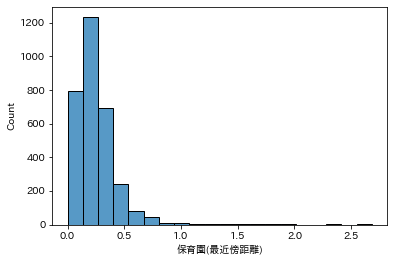

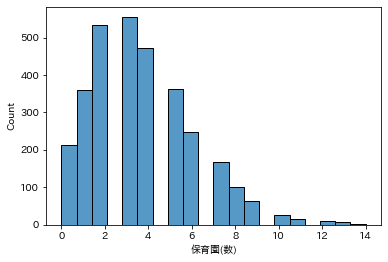

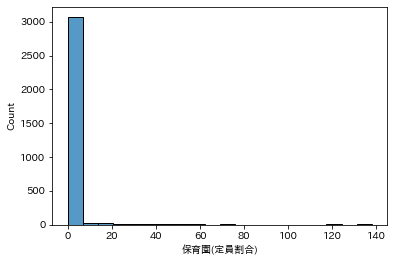

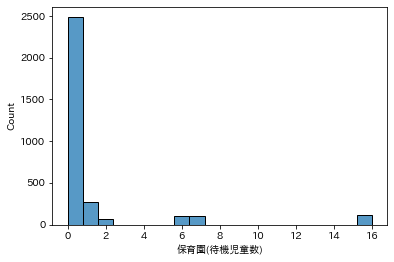

In [25]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [26]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

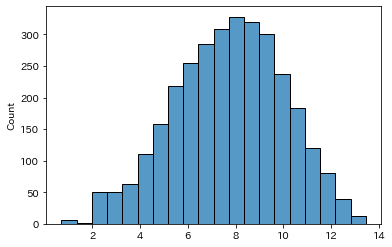

In [27]:
sns.histplot(_tmp_score, bins=20)
plt.show()

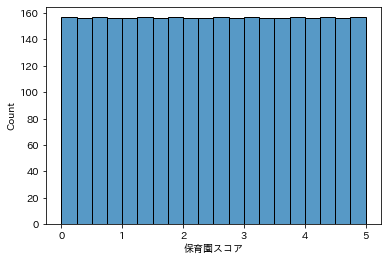

In [28]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [29]:
df_pop_master[score_name].describe()

count    3129.000000
mean        2.500000
std         1.444068
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 保育園スコア, dtype: float64

### 児童館スコア

In [30]:
score_name = '児童館スコア'
feature_list = {
    '児童館(最近傍距離)':       {'sort': -1, 'weight': 1}, 
    '児童館(数)':               {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

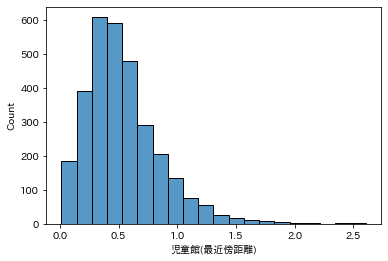

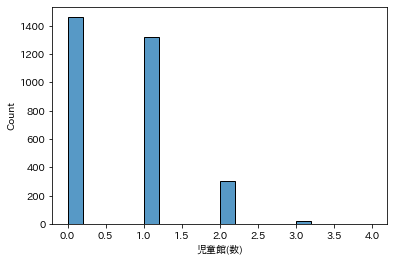

In [31]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [32]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

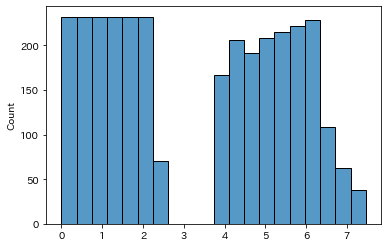

In [33]:
sns.histplot(_tmp_score, bins=20)
plt.show()

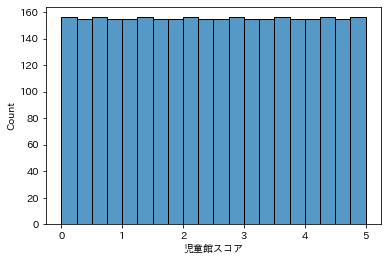

In [34]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [35]:
df_pop_master[score_name].describe()

count    3108.000000
mean        2.500000
std         1.444072
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 児童館スコア, dtype: float64

### 保存

In [36]:
all_feature_list

['保育園(最近傍距離)', '保育園(数)', '保育園(定員割合)', '保育園(待機児童数)', '児童館(最近傍距離)', '児童館(数)']

In [37]:
all_score_list

['保育園スコア', '児童館スコア']

In [38]:
df_pop_master['保育園(最近傍距離)'] = df_pop_master['保育園(最近傍距離)'].round(3)
df_pop_master['児童館(最近傍距離)'] = df_pop_master['児童館(最近傍距離)'].round(3)
df_pop_master['保育園(定員割合)'] = df_pop_master['保育園(定員割合)'].round(2)
for col in all_score_list:
    df_pop_master[col] = df_pop_master[col].round(2)

In [39]:
df_pop_master[
    ['town_id'] + all_feature_list + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False, encoding='utf-8_sig')

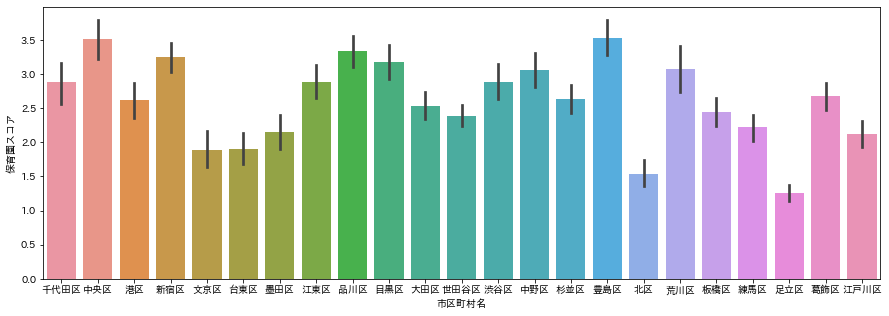

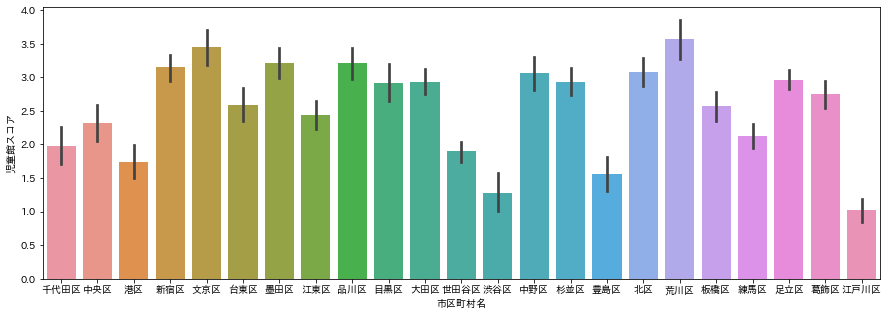

In [40]:
for _score in all_score_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_pop_master)
    plt.show()

In [41]:
def get_score_top(df_data, target, ):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    feature_cols = [col for col in all_feature_list if col.startswith(target)]
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + feature_cols + [score_name]
    ].reset_index(drop=True)
    return df_level

In [42]:
df_level = get_score_top(df_pop_master, '保育園')
print(df_level.shape)
df_level.head(10)

(903, 8)


,市区町村名,町名,町丁目,保育園(最近傍距離),保育園(数),保育園(定員割合),保育園(待機児童数),保育園スコア
0,中央区,入船,入船３丁目,0.019,7.0,1.00,0,5.00
1,練馬区,関町東,関町東２丁目,0.022,7.0,2.15,0,5.00
2,杉並区,上荻,上荻１丁目,0.031,8.0,1.34,0,5.00
3,中央区,日本橋人形町,日本橋人形町３丁目,0.004,12.0,0.88,0,5.00
4,品川区,東中延,東中延２丁目,0.038,8.0,0.92,0,4.99
5,品川区,南品川,南品川１丁目,0.065,9.0,1.02,0,4.99
6,江東区,富岡,富岡２丁目,0.070,10.0,1.11,0,4.99
7,中央区,日本橋蠣殻町,日本橋蠣殻町２丁目,0.100,9.0,2.36,0,4.99
8,江東区,白河,白河１丁目,0.058,8.0,1.05,0,4.99
9,港区,麻布台,麻布台２丁目,0.078,6.0,4.28,0,4.98


In [43]:
df_level.tail(10)

,市区町村名,町名,町丁目,保育園(最近傍距離),保育園(数),保育園(定員割合),保育園(待機児童数),保育園スコア
893,大田区,京浜島,京浜島１丁目,1.094,0.0,0.0,0,0.06
894,千代田区,皇居外苑,皇居外苑,1.217,0.0,0.0,0,0.05
895,千代田区,日比谷公園,日比谷公園,1.253,0.0,0.0,0,0.05
896,大田区,東海,東海１丁目,1.199,0.0,0.0,0,0.05
897,品川区,東八潮,東八潮,1.098,0.0,0.0,0,0.05
898,江東区,新木場,新木場１丁目,1.601,0.0,0.0,0,0.04
899,大田区,城南島,城南島７丁目,2.682,0.0,0.0,0,0.02
900,足立区,古千谷,古千谷２丁目,0.628,0.0,0.0,1,0.01
901,足立区,舎人公園,舎人公園,0.833,0.0,0.0,1,0.00
902,足立区,西伊興町,西伊興町,0.650,0.0,0.0,1,0.00


In [44]:
df_level = get_score_top(df_pop_master, '児童館')
print(df_level.shape)
df_level.head(10)

(901, 6)


,市区町村名,町名,町丁目,児童館(最近傍距離),児童館(数),児童館スコア
0,新宿区,東五軒町,東五軒町,0.029,2.0,5.00
1,大田区,大森東,大森東１丁目,0.016,2.0,5.00
2,品川区,東中延,東中延２丁目,0.038,3.0,5.00
3,杉並区,高円寺南,高円寺南３丁目,0.035,2.0,5.00
4,荒川区,荒川,荒川７丁目,0.046,2.0,4.99
5,品川区,戸越,戸越６丁目,0.117,3.0,4.99
6,中野区,鷺宮,鷺宮３丁目,0.044,2.0,4.99
7,新宿区,中井,中井１丁目,0.037,2.0,4.99
8,墨田区,立花,立花５丁目,0.043,2.0,4.99
9,練馬区,光が丘,光が丘１丁目,0.045,2.0,4.99


In [45]:
df_level.tail(10)

,市区町村名,町名,町丁目,児童館(最近傍距離),児童館(数),児童館スコア
891,大田区,京浜島,京浜島１丁目,1.458,0.0,0.08
892,世田谷区,玉堤,玉堤２丁目,1.454,0.0,0.08
893,江戸川区,東葛西,東葛西２丁目,1.472,0.0,0.08
894,渋谷区,代々木神園町,代々木神園町,1.492,0.0,0.07
895,江戸川区,東篠崎町,東篠崎町,1.559,0.0,0.06
896,江戸川区,清新町,清新町１丁目,1.601,0.0,0.05
897,江東区,新木場,新木場１丁目,1.697,0.0,0.04
898,千代田区,日比谷公園,日比谷公園,1.675,0.0,0.04
899,千代田区,皇居外苑,皇居外苑,1.881,0.0,0.02
900,江戸川区,南葛西,南葛西１丁目,2.279,0.0,0.01
